In [581]:
from src import *
import os
# Visualizing the original fmri
from nilearn import image
from nilearn import plotting
from nilearn.plotting import plot_epi, show

import torch
import torch.nn as nn

In [485]:
def get_aggprop(h5dict, property):
    """
    Get the bundles statistics on whole brain level
    """
    try:
        ret = np.array(h5dict.get('matrices').get(property))
    except:
        print('Not valid property OR h5 not opened')
    return ret

def get_bundles_betweenreg(h5dict, r1, r2, verbose=True):
    """
    Get the bundles voxels spots linking two regions of interest
    """

    bundle_r = str(r1) + '_' + str(r2)

    # Check if bundle link exists
    feasible = np.array(list(set(np.array(h5dict.get('atlas')))))
    valid_regions = set([f.split('_')[0] for f in feasible] + [f.split('_')[1] for f in feasible])

    if not ((str(r1) in valid_regions) and (str(r2) in valid_regions)):
        if verbose: print('Regions inputed are not valid')
        return

    if bundle_r not in feasible:
        if verbose: print('Regions {} and {} are not sufficiently connected'.format(r1, r2))
        return
    

    ret = np.array(h5dict.get('atlas').get(bundle_r))
    return ret

def mean_fmri(nifti):
    """
    Compute mean (across time) fmri volume
    """

    affine = nifti.affine
    volume = nifti.get_fdata()
    mean_volume = volume.mean(axis=-1)
    ret = nib.Nifti1Image(mean_volume, affine=affine)
    return ret

def abs_nifti(nifti):
    """
    Compute absolute value nifti file
    """

    affine = nifti.affine
    volume = nifti.get_fdata()    
    ret = nib.Nifti1Image(np.abs(volume), affine=affine)
    return ret

def volcoord2mnicoord(arrays, affine):
    """
    Compute volume coords to mni coords transform
    """
    # ret = []
    # for arr in arrays:
    #     ret.append(nimg.coord_transform(arr[0],arr[1],arr[2], affine))
    tmp = np.concatenate([arrays,np.ones((arrays.shape[0],1))], axis=1)
    ret = np.matmul(affine,tmp.T)[:3].T

    return np.array(ret).astype(float)

def mnicoord2volcoord(arrays, affine):
    """
    Compute volume coords from mni coords transform
    """
    inv_affine = np.linalg.inv(affine)
    # ret = []
    # for arr in arrays:
    #     ret.append(nimg.coord_transform(arr[0],arr[1],arr[2], inv_affine))
    tmp = np.concatenate([arrays,np.ones((arrays.shape[0],1))], axis=1)
    ret = np.matmul(inv_affine,tmp.T)[:3].T

    return np.array(ret).astype(int)

## Goal

The goal of this notebook is to do inpainting

## Description



- Scale1 -> ~95
- Scale2 -> ~140
- Scale3 -> ~240

Structuring of folder h5: 
- ['atlas', 'header', 'matrices']:
    - atlas:
        - bundles 10-59
        - bundles 11-23
        - ...
    - header: 
        - affine, dim, gmcodes, gmcolors, gmcoords, gmregions, nsubjects, voxsize
    - matrices:
        - consistency
        - length
        - numbStlines

In [486]:
connFilename = '../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale1.h5'
hf = h5py.File(connFilename, 'r')

In [585]:
rest_runs = os.listdir('../atlas_data/rstfMRI_eg/rst_fmri_moviedata/')

In [587]:
centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
# Load the rest fmri in MNI space volumes
rst_vols = [nib.load('../atlas_data/rstfMRI_eg/rst_fmri_moviedata/{}'.format(run)) for run in rest_runs]

### Statistic Views

In [488]:
consistency_view = get_aggprop(hf, 'consistency')
length_view = get_aggprop(hf, 'length')
nbStlines_view = get_aggprop(hf, 'numbStlines')
nb_regions = consistency_view.shape[0]

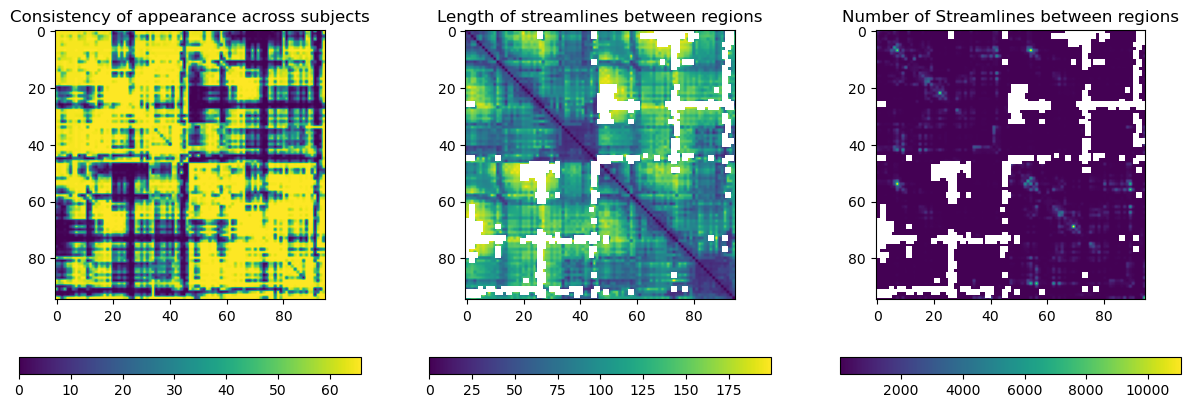

In [490]:
# Ploting the stats view
fig, ax = plt.subplots(1,3, figsize=(15,5))
im0 = ax[0].imshow(consistency_view)
im1 = ax[1].imshow(length_view)
im2 = ax[2].imshow(nbStlines_view)
ax[0].set_title('Consistency of appearance across subjects')
ax[1].set_title('Length of streamlines between regions')
ax[2].set_title('Number of Streamlines between regions')
fig.colorbar(im0,  orientation='horizontal')
fig.colorbar(im1,  orientation='horizontal')
fig.colorbar(im2,  orientation='horizontal')

### StreamLines specifics

In [491]:
streamline = get_bundles_betweenreg(hf, 3,78)

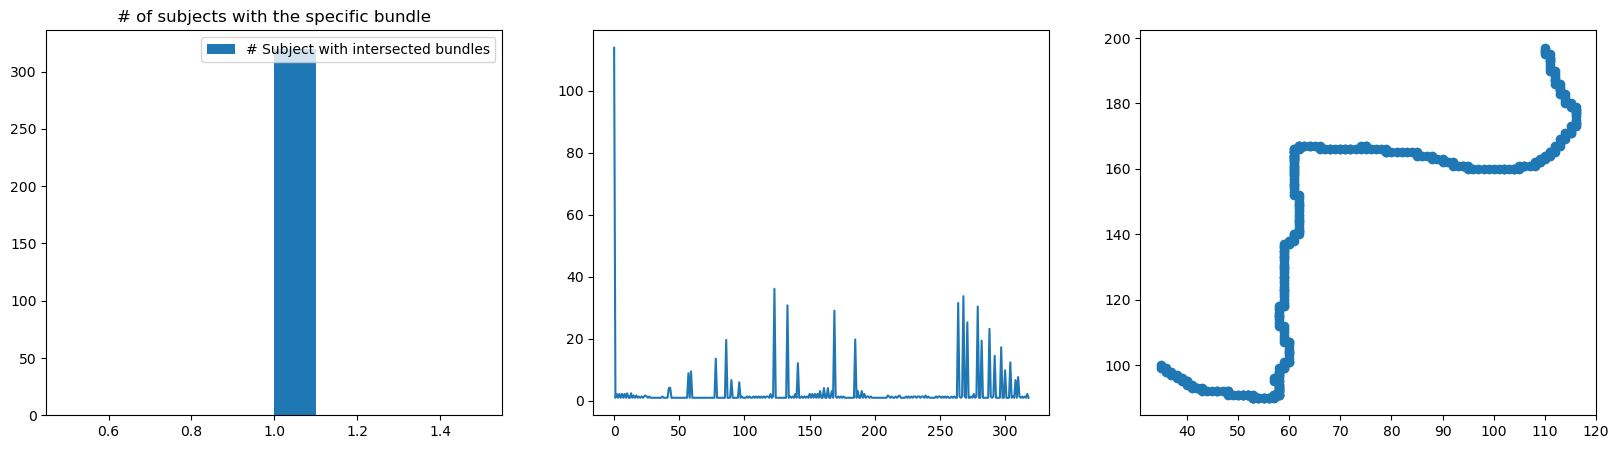

In [492]:
path_motion = []
coords = streamline[:,[0,1,2]]
for k in range(streamline.shape[0]-1):
    dist = np.sqrt(np.sum((coords[k] - coords[k-1]) ** 2))
    path_motion.append(dist)

fig ,ax = plt.subplots(1,3, figsize=(20,5))
ax[0].hist(streamline[:,3], label='# Subject with intersected bundles')
ax[0].set_title('# of subjects with the specific bundle')
ax[0].legend()
ax[1].plot(path_motion)
ax[2].scatter(coords[:,0],coords[:,1])
# plt.xlim(0,100)

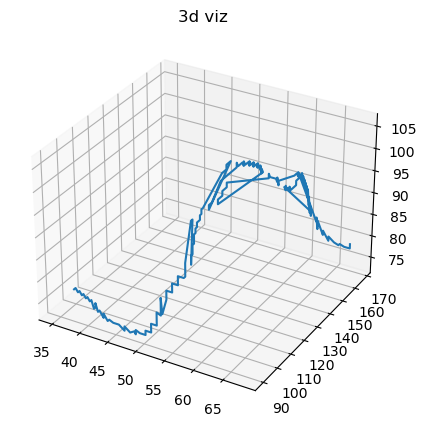

In [493]:
fig,axs = plt.subplots(1,1,subplot_kw=dict(projection='3d'),figsize=(5,5))

length_order = 200
x=coords[:,0][:length_order]
y=coords[:,1][:length_order]
z=coords[:,2][:length_order]

axs.plot(x,y,z)
axs.set_title('3d viz')
plt.show()

### Computing seed connectivity between regions Atlased

Idea is to obtain a $y$ value for each of the fibers to compute connectivity

In [591]:
rest_affine = rst_vols[0].affine
ftimecourses = [rst.get_fdata() for rst in rst_vols]
ftimecourses = np.asarray(ftimecourses)
ftimecourse = ftimecourses.mean(axis=0)

In [599]:
rst_vol = nib.Nifti1Image(ftimecourse, affine=rest_affine)

In [611]:
# seed functional connectivity on PCC
seedfunc_vol = np.zeros((ftimecourse.shape[:-1]))
for x in tqdm(range(seedfunc_vol.shape[0])):
    for y in range(seedfunc_vol.shape[1]):
        for z in range(seedfunc_vol.shape[2]):
            seedfunc_vol[x,y,z] = pearsonr(ftimecourse[48,52,55], ftimecourse[x,y,z])[0]
            seedfunc_vol[x,y,z] += pearsonr(ftimecourse[41,53,55], ftimecourse[x,y,z])[0]
            seedfunc_vol[x,y,z] /= 2

  0%|          | 0/91 [00:00<?, ?it/s]/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 91/91 [05:57<00:00,  3.93s/it]


/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


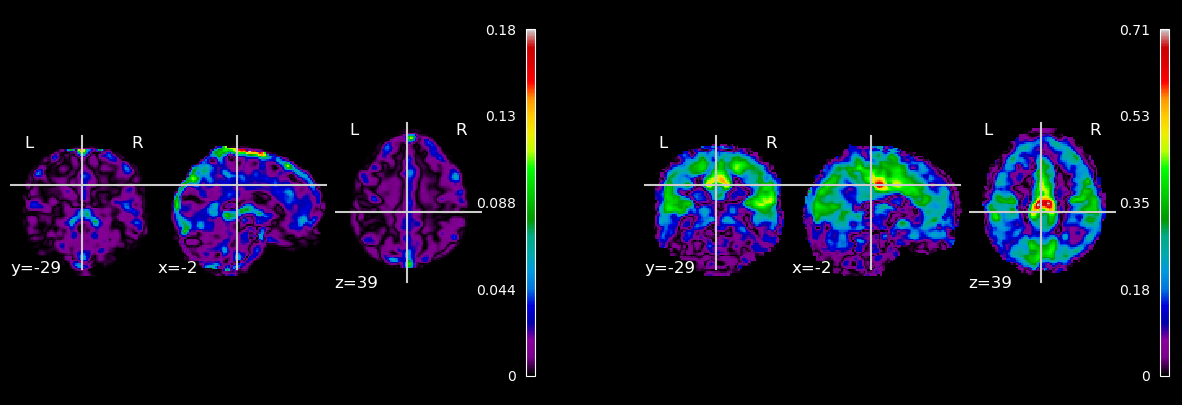

In [612]:
fig,ax = plt.subplots(1,2, figsize=(15,5), facecolor='black')
# @ PCC
plot_epi(abs_nifti(mean_fmri(rst_vol)), colorbar=True, cut_coords=(-2,-29,39), axes=ax[0])
# Visualizing the functional connectivity strength by seed connectivity (seed -> PCC)
plot_epi(abs_nifti(nib.Nifti1Image(seedfunc_vol, affine=rest_affine)), colorbar=True, cut_coords=(-2,-29,39), axes=ax[1])

In [613]:
# 1. Transform the voxels to coordinates
# 2. Match the coordinates i.e the voxels to a given label
# 3. Obtain an mapping of a voxel to the parcels

labels_vol = np.zeros(rst_vol.shape[:3])
for x in tqdm(range(rst_vol.shape[0])):
    for y in range(rst_vol.shape[1]):
        for z in range(rst_vol.shape[2]):
            # Find the MNI coordinates of the voxel (x, y, z)
            spatial_coord = np.array(image.coord_transform(x, y, z, rst_vol.affine))
            labels_vol[x,y,z] = np.argmin(np.sum((centers - spatial_coord) ** 2, axis=1))

# Atlas averaging timecourses
avg_tc = np.zeros((centers.shape[0], rst_vol.shape[-1]))
for t in tqdm(range(rst_vol.shape[-1])):
    tmp = rst_vol.get_fdata()[:,:,:,t]
    for k in range(centers.shape[0]):
        indexes = (labels_vol == k)
        nonzero = tmp[indexes][(tmp[indexes] != 0)]
        avg_tc[k,t] = nonzero.mean()

100%|██████████| 460/460 [00:27<00:00, 16.69it/s]


In [614]:
gmregions_names = hf.get('header').get('gmregions')[()]
# isolating the PCC
cand = ['cingulate' in gmregions_names.astype(str)[k] for k in range(len(gmregions_names.astype(str)))]
gmregions_names.astype(str)[np.where(cand)[0]]

array(['ctx-rh-rostralanteriorcingulate',
       'ctx-rh-caudalanteriorcingulate', 'ctx-rh-posteriorcingulate',
       'ctx-rh-isthmuscingulate', 'ctx-lh-rostralanteriorcingulate',
       'ctx-lh-caudalanteriorcingulate', 'ctx-lh-posteriorcingulate',
       'ctx-lh-isthmuscingulate'], dtype='<U49')

In [615]:
region_of_interest = ['ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate']
index_of_interest = [np.where(gmregions_names.astype(str) == r)[0][0] 
                     for r in region_of_interest]

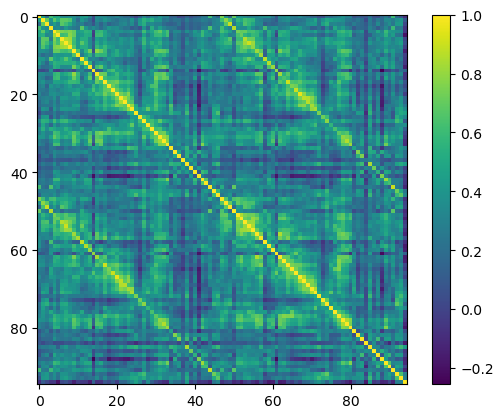

In [616]:
corr_mat = np.zeros((avg_tc.shape[0],avg_tc.shape[0]))
for k in range(avg_tc.shape[0]):
    corr_mat[k] = nta.SeedCorrelationAnalyzer(avg_tc[k], avg_tc).corrcoef

plt.imshow(corr_mat)
plt.colorbar()

### Computing regularized regression on fibers combination for seed functional connectivity explanation

In [617]:
def consistency_regularizer(x, C):
    """
    Compute regularizer dependent on consistency following:
    Lower consistency increase penalization
    """
    inv_C = (1 / C)
    ret = ((inv_C * x) ** 2).sum() / C.shape[0]
    return ret

#### 1. End-region encoded vectors

In [618]:
thresh_subjapp = nsubject * 0.15 # consider bundles that appaear at least in 30 % of the subjects

In [619]:
# Generating the X samples and the y samples
# 1. Careful as well to remove the auto-correlation in the diagonal
# 2. Raster scan parsing meaning that it is the activity of (R0,R1) -> (R0,R2) -> (R0,R3) etc...
# Define matrix of end points on cortex
X = []
bundles_labels = []
pairs = np.zeros((nb_regions, nb_regions))
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] > (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))
        pairs[i-1,j-1] = 1.0
        vec = np.zeros(nb_regions)
        vec[i-1] = 1.0
        vec[j-1] = 1.0
        X.append(vec)

X = np.asarray(X)

  0%|          | 0/95 [00:00<?, ?it/s]

100%|██████████| 95/95 [00:30<00:00,  3.10it/s]


In [620]:
# Compute a regularizer taking into account the probability of a voxel belonging to the fibers
# Here is the loss we consider
sparsing_distrib = 2
Cscale1 = (np.array([consistency_view[p[0]-1,p[1]-1]/nsubject for p in bundles_labels])) ** sparsing_distrib

In [621]:
# #Using mean connectivity of all regions
# y = (corr_mat - np.eye((nb_regions))).mean(axis=0)

# #Using connectivity again PCC
y = corr_mat[index_of_interest].mean(axis=0)

In [622]:
regularizers = np.sort(np.concatenate([np.logspace(0,5,6), np.logspace(0,5,6) / 2]))

coefs = []
scores = []
for k in tqdm(range(len(regularizers))):
    clf = Ridge(alpha=regularizers[k])
    clf.fit(X.T, y)
    scores.append(((clf.predict(X.T) - y) ** 2).mean())
    coefs.append(clf.coef_)

100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


In [623]:
regularizers_lasso = np.sort(np.concatenate([np.logspace(-5,0,6), np.logspace(-5,0,6) / 2]))
coefs_lasso = []
scores_lasso = []
for k in tqdm(range(len(regularizers_lasso))):
    clf = Lasso(alpha=regularizers_lasso[k])
    clf.fit(X.T, y)
    scores_lasso.append(((clf.predict(X.T) - y) ** 2).mean())
    coefs_lasso.append(clf.coef_)

  0%|          | 0/12 [00:00<?, ?it/s]/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.391e-04, tolerance: 2.889e-04
  model = cd_fast.enet_coordinate_descent(
100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Bundle probability regularizer accounted linear regression

In [624]:
torch.manual_seed(99)
# Model defining
lreg = nn.Sequential(
    nn.Linear(len(X), 1),
)

# Optimization step
num_epochs = 1000
lr = 1e-3

# Use L1 loss for sparsity of weights
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(lreg.parameters(), lr=0.001)

Xtorch = torch.Tensor(X.T)
ytorch = torch.Tensor(y[:,None])
for n in tqdm(range(num_epochs)):
    y_pred = lreg(Xtorch)

    reg_loss = consistency_regularizer(lreg[0].weight[0], torch.Tensor(Cscale1))
    l1_regloss = torch.linalg.vector_norm(lreg[0].weight[0], ord=1)
    genloss = loss_func(y_pred, ytorch)
    # loss =  genloss + reg_loss + l1_regloss
    loss =  genloss + reg_loss
    # if n % 100 == 0:
    #     print(genloss, l1_regloss, reg_loss)

    # Add regularizer considering consistency of bundles
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

mlp_weight = lreg[0].weight.detach().numpy()[0]
print(consistency_regularizer(mlp_weight, Cscale1))

100%|██████████| 1000/1000 [00:00<00:00, 1440.91it/s]

0.00015319392841401833


0.0005246895614567775

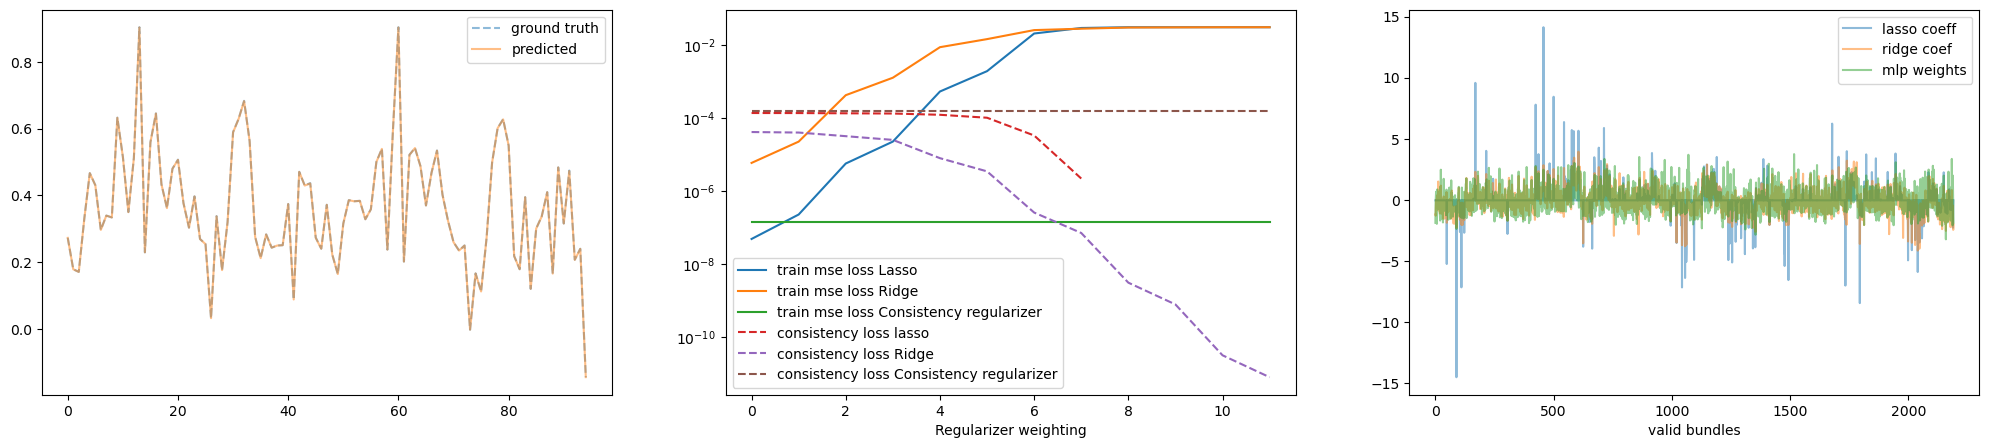

In [625]:
lreg_scores = np.zeros_like(scores)
lreg_scores[:] = loss_func(y_pred, ytorch).detach().item()

consistency_scores_lasso = np.array([consistency_regularizer(coefs_lasso[i], Cscale1) for i in range(len(coefs_lasso))])
consistency_scores = np.array([consistency_regularizer(coefs[i], Cscale1) for i in range(len(coefs))])
consistency_scores_lasso[consistency_scores_lasso == 0] = np.nan
consistency_scores[consistency_scores == 0] = np.nan
consistency_scores_lreg = np.zeros_like(scores)
consistency_scores_lreg[:] = consistency_regularizer(mlp_weight, Cscale1)

fig, ax = plt.subplots(1, 3, figsize=(25,5))

ax[0].plot(ytorch.detach().numpy().flatten(), label='ground truth', linestyle='--', alpha=0.5)
ax[0].plot(y_pred.detach().numpy().flatten(), label='predicted', alpha=0.5)
ax[0].legend()

ax[1].plot(scores_lasso, label='train mse loss Lasso')
ax[1].plot(scores, label='train mse loss Ridge')
ax[1].plot(lreg_scores, label='train mse loss Consistency regularizer')
ax[1].set_yscale('log')

ax[1].plot(consistency_scores_lasso, linestyle='--', label='consistency loss lasso')
ax[1].plot(consistency_scores, linestyle='--', label='consistency loss Ridge')
ax[1].plot(consistency_scores_lreg, linestyle='--', label='consistency loss Consistency regularizer')
ax[1].legend()
ax[1].set_xlabel('Regularizer weighting')

# The different coefs chosen and regularizers choen
ax[2].plot(zscore(coefs_lasso[4]), label='lasso coeff', alpha=0.5)
ax[2].plot(zscore(coefs[3]), label='ridge coef', alpha=0.5)
ax[2].plot(zscore(mlp_weight), label='mlp weights', alpha=0.5)
ax[2].set_xlabel('valid bundles')
ax[2].legend()

scores_lasso[np.argmax(np.abs(np.diff(scores_lasso)))-1]

### Reconstruction of the fMRI timecourses in WM bundles / voxels levels

- Bring back the GM voxel level timecourses
- Assign timecourse value on voxel being the weighted value of a voxel (so can regenerate WM volumes first then average)
- Recompute the seed connectivity of a given region versus all and show it on the volume (voxel levels)

In [626]:
bundle_affine = np.array(hf.get('header').get('affine'))[()]

Making Access easier - transforming bundles to fmri coordinates / fmri volumes masks

In [574]:
trans_affine = np.matmul(np.linalg.inv(rest_affine), bundle_affine)

fmri_coords = []
for k in tqdm(range(len(bundles_labels))):
    i,j = bundles_labels[k]
    streamline = get_bundles_betweenreg(hf, i,j)
    streamline = streamline[streamline[:,3] > thresh_subjapp]

    # Transform voxel indexes of a volume to voxel index of another volume
    volcoords_interest = volcoord2mnicoord(streamline[:,[0,1,2]], trans_affine).astype(int)
    fmri_coords.append(volcoords_interest)

# Save the space coords matching
save('./resources/scale1_fmri2atlas_coords_div{}.pkl'.format(int(np.ceil(thresh_subjapp))), fmri_coords)

  0%|          | 0/2192 [00:00<?, ?it/s]

100%|██████████| 2192/2192 [01:36<00:00, 22.67it/s]


In [628]:
fmri_coords = load('./resources/scale1_fmri2atlas_coords_div{}.pkl'.format(int(np.ceil(thresh_subjapp))))

Interpolate the connectivity of WM bundles at voxel levels

In [629]:
vdim = ftimecourse.shape[:3]

In [630]:
def interpolate_connectivity(fmri_bundles, bundles_ij, rcomb, regions_correlation, dim):
    """
    Compute interpolated connectivity on white matter bundles
    """
    # Iterate across all the bundles and populate each voxels by the timcourses
    wm_inpainted = np.zeros(dim)
    for k in tqdm(range(len(bundles_ij))):
        i,j = bundles_ij[k]

        volcoords_interest = fmri_bundles[k]
        avg_betweenbundle_conn = regions_correlation[i-1,j-1]

        for coord in volcoords_interest:
            x,y,z = coord
            wm_inpainted[x,y,z] = wm_inpainted[x,y,z] + rcomb[k] *  avg_betweenbundle_conn
    
    return wm_inpainted

In [631]:
wm_inpainted_lasso = interpolate_connectivity(fmri_coords, bundles_labels, coefs_lasso[4], corr_mat, vdim)
wm_inpainted_ridge = interpolate_connectivity(fmri_coords, bundles_labels, coefs[3], corr_mat, vdim)
wm_inpainted_lreg = interpolate_connectivity(fmri_coords, bundles_labels, mlp_weight, corr_mat, vdim)

  0%|          | 0/2192 [00:00<?, ?it/s]

100%|██████████| 2192/2192 [00:20<00:00, 109.37it/s]


Text(0.5, 1.0, 'Lreg')

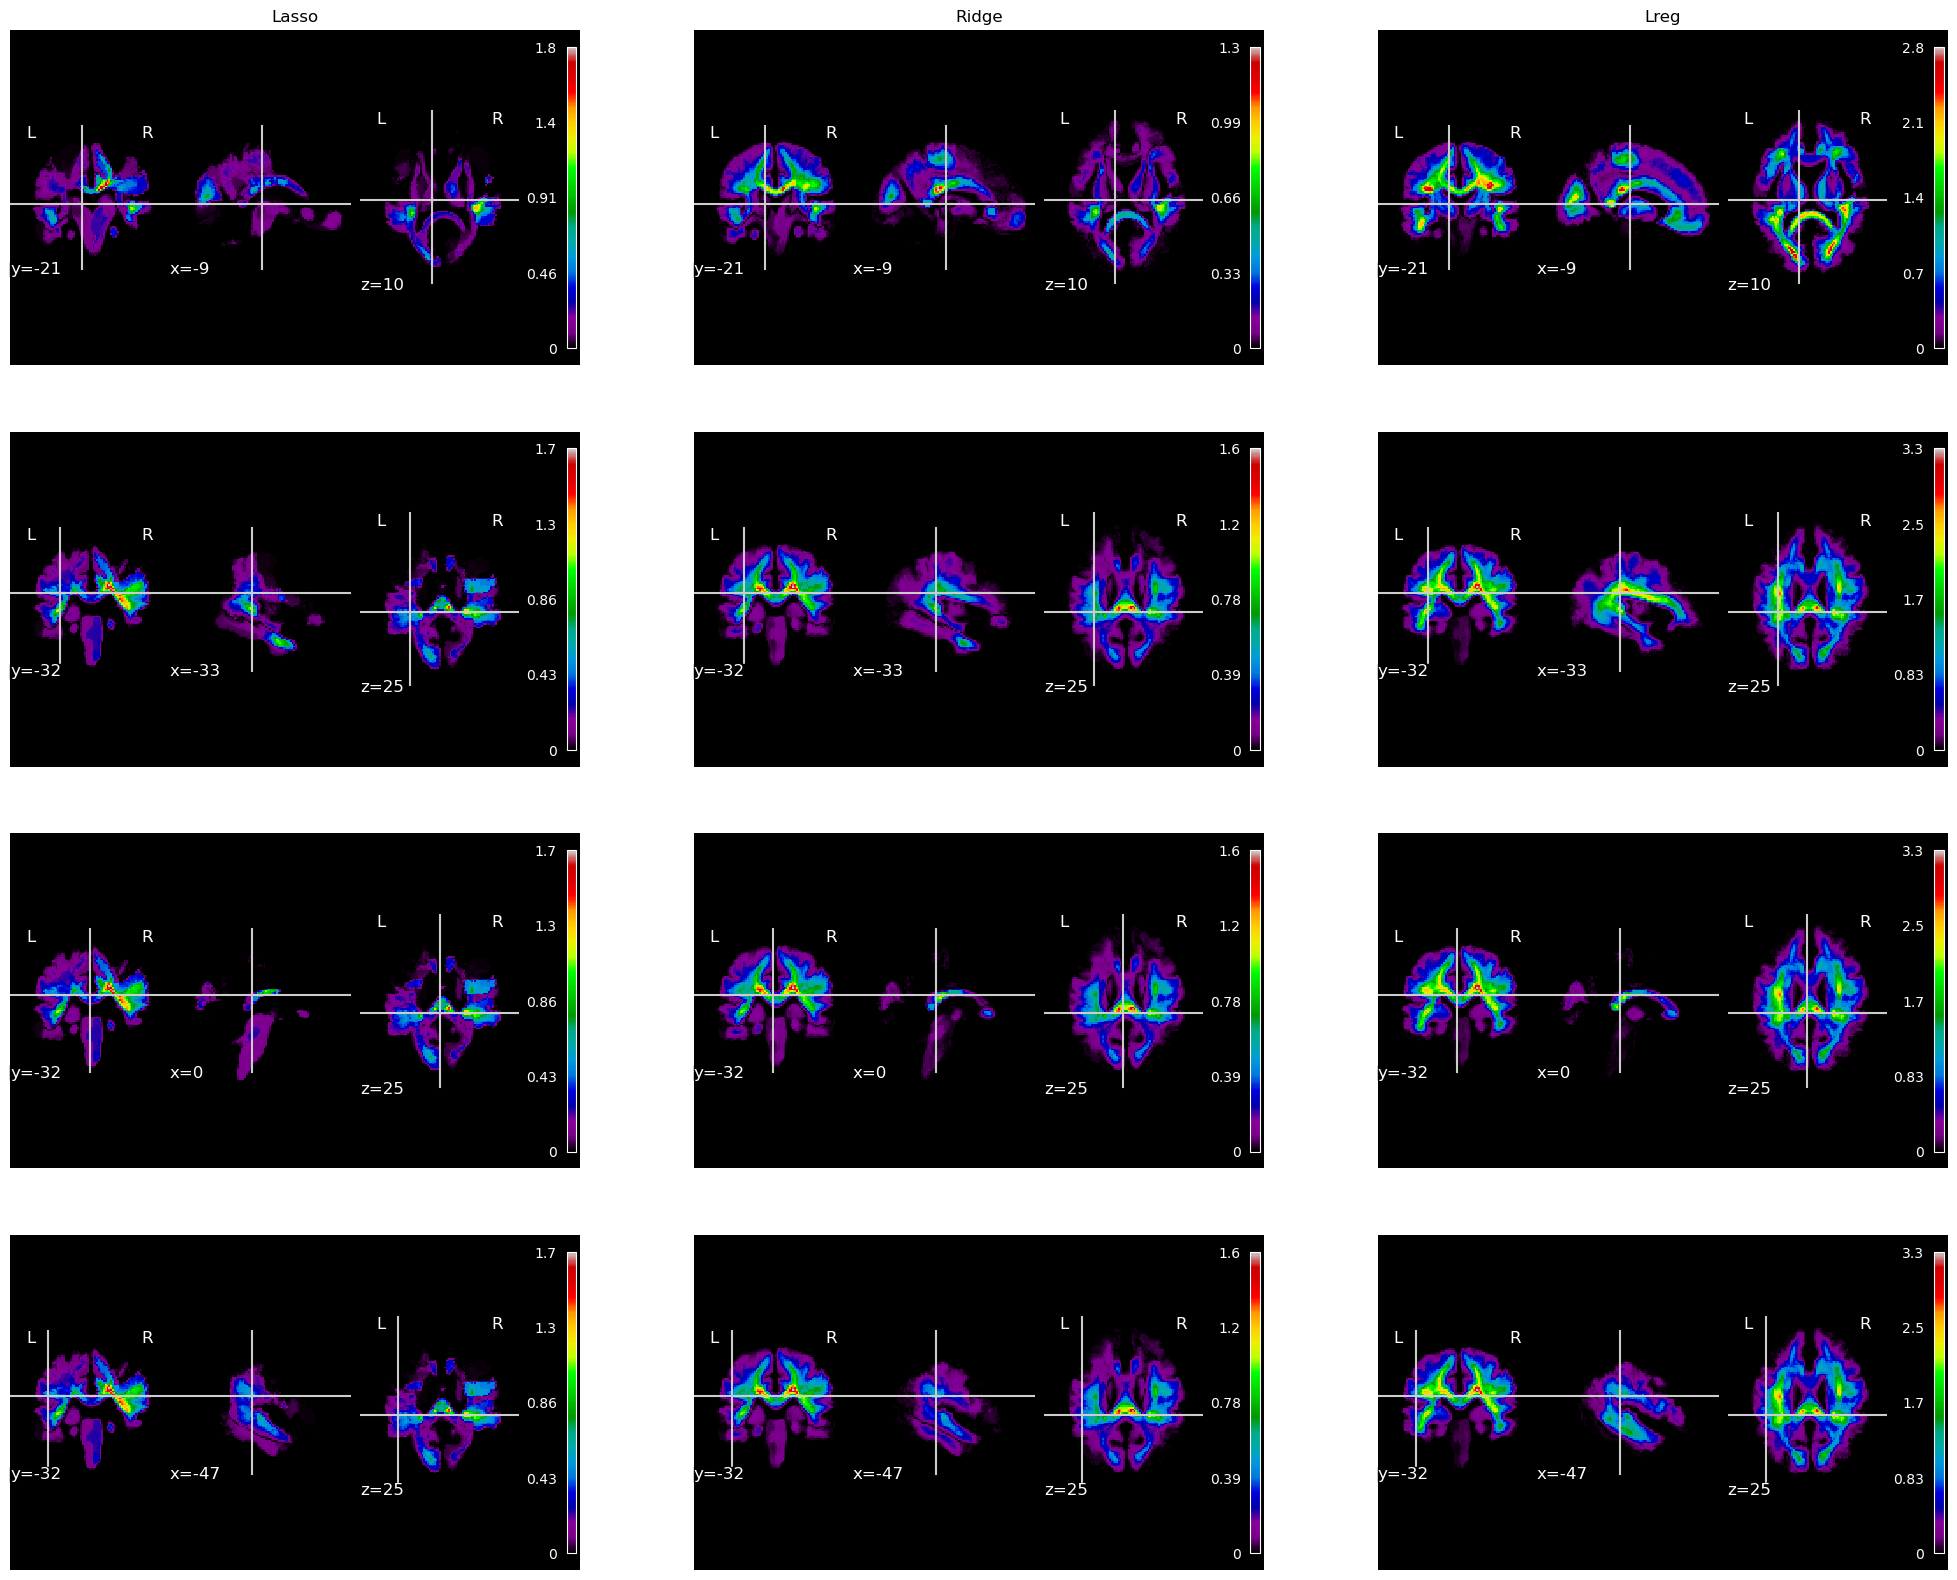

In [642]:
slicecoords_set = [(-9,-21,10), (-33,-32,25), (0,-32,25), (-47,-32,25)]
fig, ax = plt.subplots(4,3, figsize=(25,20))
plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_lasso, affine=rest_affine)), colorbar=True, cut_coords=slicecoords_set[0], axes=ax[0,0])
plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_ridge, affine=rest_affine)), colorbar=True, cut_coords=slicecoords_set[0], axes=ax[0,1])
plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_lreg, affine=rest_affine)), colorbar=True, cut_coords=slicecoords_set[0], axes=ax[0,2])

plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_lasso, affine=rest_affine)), colorbar=True, cut_coords=slicecoords_set[1], axes=ax[1,0])
plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_ridge, affine=rest_affine)), colorbar=True, cut_coords=slicecoords_set[1], axes=ax[1,1])
plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_lreg, affine=rest_affine)), colorbar=True, cut_coords=slicecoords_set[1], axes=ax[1,2])

plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_lasso, affine=rest_affine)), colorbar=True, cut_coords=slicecoords_set[2], axes=ax[2,0])
plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_ridge, affine=rest_affine)), colorbar=True, cut_coords=slicecoords_set[2], axes=ax[2,1])
plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_lreg, affine=rest_affine)), colorbar=True, cut_coords=slicecoords_set[2], axes=ax[2,2])

plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_lasso, affine=rest_affine)), colorbar=True, cut_coords=slicecoords_set[3], axes=ax[3,0])
plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_ridge, affine=rest_affine)), colorbar=True, cut_coords=slicecoords_set[3], axes=ax[3,1])
plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_lreg, affine=rest_affine)), colorbar=True, cut_coords=slicecoords_set[3], axes=ax[3,2])

ax[0,0].set_title('Lasso')
ax[0,1].set_title('Ridge')
ax[0,2].set_title('Lreg')

In [479]:
# # use the masks if necessary when we select too much bundles for reconstruction
# gm_mask_subj = nib.load('../atlas_data/rstfMRI_eg/gm_mask_subj7.nii')
# wm_mask_subj = (gm_mask_subj.get_fdata() + 1) % 2

In [ ]:
# NOTE: Close the opened h5 file
hf.close()

Interpolating using fmri timecourse instead of connectivity

In [ ]:
# # INTERPOLATE fMRI TIMECOURSE
# # Iterate across all the bundles and populate each voxels by the timcourses
# wm_inpainted = np.zeros_like(ftimecourse)
# for k in tqdm(range(len(bundles_labels))):
#     i,j = bundles_labels[k]
#     volcoords_interest = fmri_coords[k]
#     avg_betweenbundle_course = (avg_tc[i-1] + avg_tc[j-1])/2

#     for coord in volcoords_interest:
#         x,y,z = coord
#         wm_inpainted[x,y,z,:] = wm_inpainted[x,y,z,:] + coefs2use[k] *  avg_betweenbundle_course

# seedfunc_vol_WM = np.zeros((ftimecourse.shape[:-1]))
# for x in tqdm(range(seedfunc_vol_WM.shape[0])):
#     for y in range(seedfunc_vol_WM.shape[1]):
#         for z in range(seedfunc_vol_WM.shape[2]):
#             seedfunc_vol_WM[x,y,z] = pearsonr(wm_inpainted[46,48,55], wm_inpainted[x,y,z])[0]

In [480]:
# # compute the masks for different scales for each bundles (1 mask for 1 bundle)
# trans_affine = np.matmul(np.linalg.inv(rest_affine), bundle_affine)

# fmri_masks = []
# for k in tqdm(range(len(bundles_labels))):
#     i,j = bundles_labels[k]
#     streamline = get_bundles_betweenreg(hf, i,j)
#     # Transform voxel indexes of a volume to voxel index of another volume
#     volcoords_interest = volcoord2mnicoord(streamline[:,[0,1,2]], trans_affine).astype(int)

#     # fmri_coords.append(volcoords_interest)
#     tmp_mask = np.zeros_like(ftimecourse[:,:,:,0])
#     for coord in volcoords_interest:
#         x,y,z = coord
#         tmp_mask[x,y,z] = 1.0
#     fmri_masks.append(tmp_mask)

# # Save the space coords matching
# save('./resources/scale1_fmri2atlas_mask.pkl', fmri_masks)